In [11]:
!unzip hw2_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: hw2_data/digits/mnistm/data/52518.png  
  inflating: hw2_data/digits/mnistm/data/03031.png  
  inflating: hw2_data/digits/mnistm/data/25948.png  
  inflating: hw2_data/digits/mnistm/data/45064.png  
  inflating: hw2_data/digits/mnistm/data/23487.png  
  inflating: hw2_data/digits/mnistm/data/03757.png  
  inflating: hw2_data/digits/mnistm/data/12882.png  
  inflating: hw2_data/digits/mnistm/data/45702.png  
  inflating: hw2_data/digits/mnistm/data/22941.png  
  inflating: hw2_data/digits/mnistm/data/33694.png  
  inflating: hw2_data/digits/mnistm/data/04038.png  
  inflating: hw2_data/digits/mnistm/data/55511.png  
  inflating: hw2_data/digits/mnistm/data/13544.png  
  inflating: hw2_data/digits/mnistm/data/05326.png  
  inflating: hw2_data/digits/mnistm/data/43373.png  
  inflating: hw2_data/digits/mnistm/data/22799.png  
  inflating: hw2_data/digits/mnistm/data/53160.png  
  inflating: hw2_data/digits/mnistm/data/15135.p

In [1]:
'''
The code is modified from
https://github.com/xiaohu2015/nngen/blob/main/models/diffusion_models,
https://github.com/TeaPearce/Conditional_Diffusion_MNIST,
https://www.bilibili.com/video/BV1b541197HX/

Diffusion model is based on "CLASSIFIER-FREE DIFFUSION GUIDANCE" and "Denoising Diffusion Implicit Models"
https://arxiv.org/abs/2207.12598,
https://arxiv.org/abs/2010.02502
'''

import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import autoaugment, RandomErasing
from glob import glob
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

%matplotlib inline

In [2]:
# use sinusoidal position embedding to encode time step (https://arxiv.org/abs/1706.03762)
def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [3]:
# define TimestepEmbedSequential to support `time_emb` as extra input
class TimestepBlock(nn.Module):
    @abstractmethod
    def foward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """

class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, t_emb, c_emb, mask):
        for layer in self:
            if(isinstance(layer, TimestepBlock)):
                x = layer(x, t_emb, c_emb, mask)
            else:
                x = layer(x)
        return x

def norm_layer(channels):
    return nn.GroupNorm(32, channels)

In [4]:
# Residual block
class Residual_block(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, class_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )

        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )

        self.class_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(class_channels, out_channels)
        )


        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )

        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, t, c, mask):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        `c` has shape `[batch_size, class_dim]`
        `mask` has shape `[batch_size, ]`
        """
        h = self.conv1(x)
        emb_t = self.time_emb(t)
        emb_c = self.class_emb(c)*mask[:, None]
        h += (emb_t[:,:, None, None] + emb_c[:,:, None, None])
        h = self.conv2(h)

        return h + self.shortcut(x)

In [5]:
# Attention block with shortcut
class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0

        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B*self.num_heads, -1, H*W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x

In [6]:
# upsample
class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

# downsample
class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self, x):
        return self.op(x)

In [7]:
class UnetModel(nn.Module):
    def __init__(self,
                 in_channels=3,
                 model_channels=128,
                 out_channels=3,
                 num_res_blocks=2,
                 attention_resolutions=(8,16),
                 dropout=0,
                 channel_mult=(1,2,2,2),
                 conv_resample=True,
                 num_heads=4,
                 class_num=21
                ):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        self.class_num = class_num

        #time embedding
        time_emb_dim = model_channels*4
        self.time_emb = nn.Sequential(
                nn.Linear(model_channels, time_emb_dim),
                nn.SiLU(),
                nn.Linear(time_emb_dim, time_emb_dim)
        )

        #class embedding
        class_emb_dim = model_channels
        self.class_emb = nn.Embedding(class_num, class_emb_dim)

        #down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_channels = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [Residual_block(ch, model_channels*mult, time_emb_dim, class_emb_dim, dropout)]
                ch = model_channels*mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_channels.append(ch)
            if level != len(channel_mult)-1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_channels.append(ch)
                ds*=2

        #middle blocks
        self.middle_blocks = TimestepEmbedSequential(
            Residual_block(ch, ch, time_emb_dim, class_emb_dim, dropout),
            AttentionBlock(ch, num_heads),
            Residual_block(ch, ch, time_emb_dim, class_emb_dim, dropout)
        )

        #up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in enumerate(channel_mult[::-1]):
            for i in range(num_res_blocks+1):
                layers = [
                    Residual_block(ch+down_block_channels.pop(), model_channels*mult,\
                                   time_emb_dim, class_emb_dim, dropout)]
                ch = model_channels*mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads))
                if level!=len(channel_mult)-1 and i==num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(ch, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, timesteps, c, mask):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param c: a 1-D batch of classes.
        :param mask: a 1-D batch of conditioned/unconditioned.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        # time step and class embedding
        t_emb = self.time_emb(timestep_embedding(timesteps, dim=self.model_channels))
        c_emb = self.class_emb(c)


        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, t_emb, c_emb, mask)
#             print(h.shape)
            hs.append(h)

        # middle stage
        h = self.middle_blocks(h, t_emb, c_emb, mask)

        # up stage
        for module in self.up_blocks:
#             print(h.shape, hs[-1].shape)
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, t_emb, c_emb, mask)

        return self.out(h)

In [8]:
# beta schedule
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def sigmoid_beta_schedule(timesteps):
    betas = torch.linspace(-6, 6, timesteps)
    betas = torch.sigmoid(betas)/(betas.max()-betas.min())*(0.02-betas.min())/10
    return betas

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [9]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='cosine'
    ):
        self.timesteps = timesteps

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        elif beta_schedule == 'sigmoid':
            betas = sigmoid_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas

        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        #self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )

        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )

    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model, x_t, t, c, w, clip_denoised=True):
        # device = next(model.parameters()).device
        # device = "cuda" if torch.cuda.is_available() else "cpu"
        # print("Type of model:", type(model))
        # if isinstance(model, dict):
        #     print("Model keys:", model.keys())
        #     raise ValueError("The 'model' argument is a dictionary (likely a state_dict) instead of a nn.Module. Please load the state_dict into the model before passing it to this method.")

        device = next(model.parameters()).device if hasattr(model, 'parameters') else x_t.device
        batch_size = x_t.shape[0]
        # predict noise using model
        pred_noise_c = model(x_t, t, c, torch.ones(batch_size).int().to(device))
        pred_noise_none = model(x_t, t, c, torch.zeros(batch_size).int().to(device))
        pred_noise = (1+w)*pred_noise_c - w*pred_noise_none

        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance

    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, c, w, clip_denoised=True):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t,
                                                c, w, clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img

    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, shape, n_class=21, w=2, mode='random', clip_denoised=True):
        batch_size = shape[0]
        # device = next(model.parameters()).device
        device = "cuda" if torch.cuda.is_available() else "cpu"

        # generate labels
        if mode == 'random':
            cur_y = torch.randint(0, n_class, (batch_size,)).to(device)
        elif mode == 'all':
            if batch_size%n_class!=0:
                batch_size = n_class
                print('change batch_size to', n_class)
            cur_y = torch.tensor([x for x in range(n_class)]*(batch_size//n_class), dtype=torch.long).to(device)
        else:
            cur_y = torch.ones(batch_size).long().to(device)*int(mode)

        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long), cur_y, w, clip_denoised)
            imgs.append(img.cpu().numpy())
        return imgs

    # sample new images
    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3, n_class=21, w=2, mode='random', clip_denoised=True):
        return self.p_sample_loop(model, (batch_size, channels, image_size, image_size), n_class, w, mode, clip_denoised)

    # use ddim to sample
    @torch.no_grad()
    def ddim_sample(
        self,
        model,
        image_size,
        batch_size=8,
        channels=3,
        ddim_timesteps=50,
        n_class = 21,
        w = 2,
        mode= 'random',
        ddim_discr_method="uniform",
        ddim_eta=0.0,
        clip_denoised=True):
        # make ddim timestep sequence
        if ddim_discr_method == 'uniform':
            c = self.timesteps // ddim_timesteps
            ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, c)))
        elif ddim_discr_method == 'quad':
            ddim_timestep_seq = (
                (np.linspace(0, np.sqrt(self.timesteps * .8), ddim_timesteps)) ** 2
            ).astype(int)
        else:
            raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')
        # add one to get the final alpha values right (the ones from first scale to data during sampling)
        ddim_timestep_seq = ddim_timestep_seq + 1
        # previous sequence
        ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])

        device = next(model.parameters()).device

        # generate labels
        if mode == 'random':
            cur_y = torch.randint(0, n_class, (batch_size,)).to(device)
        elif mode == 'all':
            if batch_size%n_class!=0:
                batch_size = n_class
                print('change batch_size to', n_class)
            cur_y = torch.tensor([x for x in range(n_class)]*(batch_size//n_class), dtype=torch.long).to(device)
        else:
            cur_y = torch.ones(batch_size).long().to(device)*int(mode)

        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        seq_img = [sample_img.cpu().numpy()]

        for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
            t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)

            # 1. get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod, prev_t, sample_img.shape)

            # 2. predict noise using model
            pred_noise_c = model(sample_img, t, cur_y, torch.ones(batch_size).int().cuda())
            pred_noise_none = model(sample_img, t, cur_y, torch.zeros(batch_size).int().cuda())
            pred_noise = (1+w)*pred_noise_c - w*pred_noise_none

            # 3. get the predicted x_0
            pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
            if clip_denoised:
                pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)

            # 4. compute variance: "sigma_t(η)" -> see formula (16)
            # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
            sigmas_t = ddim_eta * torch.sqrt(
                (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))

            # 5. compute "direction pointing to x_t" of formula (12)
            pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t**2) * pred_noise

            # 6. compute x_{t-1} of formula (12)
            x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img)

            sample_img = x_prev
            if mode == 'all':
                seq_img.append(sample_img.cpu().numpy())

        if mode == 'all':
            return seq_img
        else:
            return sample_img.cpu().numpy()

    # compute train losses
    def train_losses(self, model, x_start, t, c, mask_c):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t, c, mask_c)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

In [10]:
batch_size = 128
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
# dataset = datasets.MNIST(root='./dataset/mnist/', train=True, download=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)



class P1Dataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, dataset_name=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.dataset_name = dataset_name

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = self.df.iloc[idx, 1]

        if self.dataset_name == "svhn":
            label += 10

        if self.transform:
            image = self.transform(image)

        return image, label

current_dir = os.path.dirname("")
parent_dir = os.path.dirname(current_dir)
train_dir_mnistm = os.path.join(current_dir, "hw2_data/digits/mnistm/data")
train_csv_mnistm = os.path.join(current_dir, "hw2_data/digits/mnistm/train.csv")
train_dir_svhn = os.path.join(current_dir, "hw2_data/digits/svhn/data")
train_csv_svhn = os.path.join(current_dir, "hw2_data/digits/svhn/train.csv")

train_dataset_mnistm = P1Dataset(
        csv_file=train_csv_mnistm,
        img_dir=train_dir_mnistm,
        transform=transform,
        dataset_name="mnistm",
    )
train_dataset_svhn = P1Dataset(
    csv_file=train_csv_svhn,
    img_dir=train_dir_svhn,
    transform=transform,
    dataset_name="svhn",
)

train_dataset_combined = ConcatDataset([train_dataset_mnistm, train_dataset_svhn])

train_loader = DataLoader(
    train_dataset_combined, batch_size=batch_size, shuffle=True, drop_last=True
)



# define model and diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = UnetModel(
    in_channels=3,
    model_channels=96,
    out_channels=3,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
    class_num=21
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)

FileNotFoundError: [Errno 2] No such file or directory: 'hw2_data/digits/mnistm/train.csv'

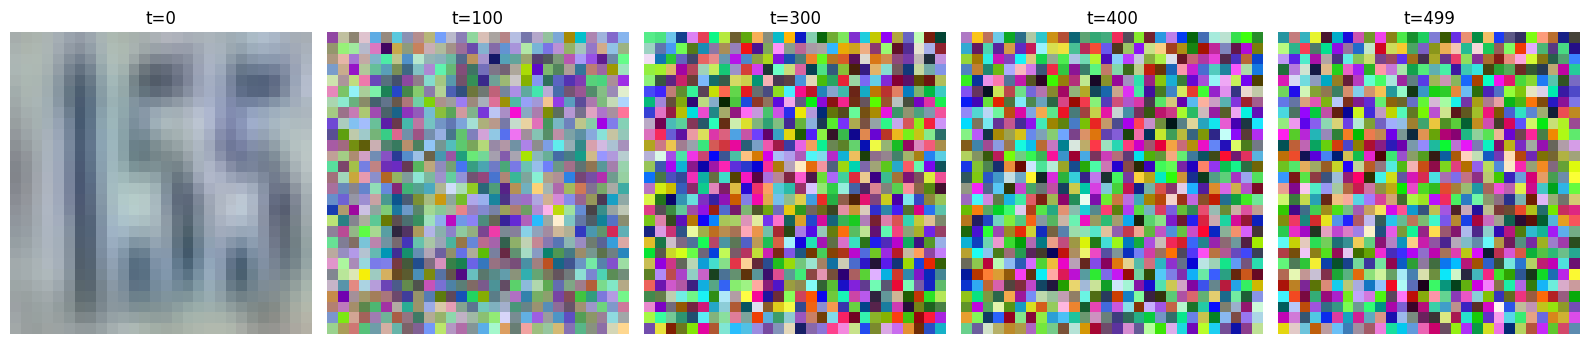

In [ ]:
image = next(iter(train_loader))[0][0].squeeze()
label = next(iter(train_loader))[1][0].squeeze()

x_start = image

gaussian_diffusion = GaussianDiffusion(timesteps=500, beta_schedule='cosine')

# plt.figure(figsize=(16, 5))
# for idx, t in enumerate([0, 100, 300, 400, 499]):
#     x_noisy = gaussian_diffusion.q_sample(x_start.to(device), t=torch.tensor([t]).to(device))
#     noisy_image = (x_noisy.squeeze() + 1) * 127.5
#     if idx==0:
#         noisy_image = (x_start.squeeze() + 1) * 127.5
#     noisy_image = noisy_image.cpu().numpy().astype(np.uint8)
#     plt.subplot(1, 5, 1 + idx)
#     plt.imshow(noisy_image)
#     plt.axis("off")
#     plt.title(f"t={t}")
# ... existing code ...

# Adjust the visualization code
plt.figure(figsize=(16, 5))
for idx, t in enumerate([0, 100, 300, 400, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start.unsqueeze(0).to(device), t=torch.tensor([t]).to(device))
    noisy_image = x_noisy.squeeze(0).permute(1, 2, 0)  # Change from [3, 28, 28] to [28, 28, 3]
    if idx == 0:
        noisy_image = x_start.permute(1, 2, 0)  # For the original image
    noisy_image = (noisy_image + 1) * 127.5
    noisy_image = noisy_image.cpu().numpy().astype(np.uint8)
    plt.subplot(1, 5, 1 + idx)
    plt.imshow(noisy_image)
    plt.axis("off")
    plt.title(f"t={t}")

plt.tight_layout()
plt.show()

In [ ]:
# train
epochs = 100
lr = 2e-5
p_uncound = 0.05
len_data = len(train_loader)
time_end = time.time()


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=epochs,  # Total number of epochs
        eta_min=1e-6,  # Minimum learning rate
    )

# checkpoint_path = "./best_model_ep_38.pt"

# model = model.to(device)
# model_dict = model.state_dict()
# pretrained_dict = torch.load(checkpoint_path)
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# model_dict.update(pretrained_dict)
# model.load_state_dict(model_dict)

model_dir = os.path.join(current_dir, f"models_ep_{epochs}_bs_{batch_size}_lr_{lr}")
os.makedirs(model_dir, exist_ok=True)
best_loss = float("inf")

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    progress_bar = tqdm(
            enumerate(train_loader),
            desc="Training Combined",
            total=len(train_loader),
        )

    for step, (images, labels) in progress_bar:
        time_start = time_end

        optimizer.zero_grad()

        batch_size = images.shape[0]
        images = images.to(device)
        labels = labels.to(device)

        # random generate mask
        z_uncound = torch.rand(batch_size)
        batch_mask = (z_uncound>p_uncound).int().to(device)

        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = gaussian_diffusion.train_losses(model, images, t, labels, batch_mask)

        # if step % 100 == 0:
        #     time_end = time.time()
        #     print("Epoch{}/{}\t  Step{}/{}\t Loss {:.4f}\t Time {:.2f}".format(epoch+1, epochs, step+1, len_data, loss.item(), time_end-time_start))

        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)

    if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(
                model.state_dict(),
                os.path.join(
                    model_dir, f"best_model_ep_{epoch+1}_loss_{best_loss:.4f}.pt"
                ),
            )
            print(f"New best loss: {best_loss:.4f} at epoch {epoch+1}. Saving model...")

        # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(
            model.state_dict(),
            os.path.join(model_dir, f"model_checkpoint_epoch_{epoch+1}.pt"),
        )

    print(
        f"Epoch:{epoch+1}/{epochs} Training Loss: {best_loss:.6f}, LR: {scheduler.get_last_lr()[0]:.6f}"
    )

Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.80it/s]


New best loss: 0.1842 at epoch 1. Saving model...
Epoch:1/100 Training Loss: 0.184238, LR: 0.000008


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0788 at epoch 2. Saving model...
Epoch:2/100 Training Loss: 0.078757, LR: 0.000002


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.83it/s]


New best loss: 0.0650 at epoch 3. Saving model...
Epoch:3/100 Training Loss: 0.064993, LR: 0.000017


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0582 at epoch 4. Saving model...
Epoch:4/100 Training Loss: 0.058179, LR: 0.000016


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0541 at epoch 5. Saving model...
Epoch:5/100 Training Loss: 0.054126, LR: 0.000001


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0515 at epoch 6. Saving model...
Epoch:6/100 Training Loss: 0.051521, LR: 0.000010


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


New best loss: 0.0495 at epoch 7. Saving model...
Epoch:7/100 Training Loss: 0.049505, LR: 0.000020


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


New best loss: 0.0475 at epoch 8. Saving model...
Epoch:8/100 Training Loss: 0.047541, LR: 0.000006


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


New best loss: 0.0463 at epoch 9. Saving model...
Epoch:9/100 Training Loss: 0.046254, LR: 0.000003


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0452 at epoch 10. Saving model...
Epoch:10/100 Training Loss: 0.045211, LR: 0.000018


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.81it/s]


New best loss: 0.0447 at epoch 11. Saving model...
Epoch:11/100 Training Loss: 0.044704, LR: 0.000014


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0439 at epoch 12. Saving model...
Epoch:12/100 Training Loss: 0.043894, LR: 0.000001


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


New best loss: 0.0431 at epoch 13. Saving model...
Epoch:13/100 Training Loss: 0.043097, LR: 0.000012


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0425 at epoch 14. Saving model...
Epoch:14/100 Training Loss: 0.042496, LR: 0.000019


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0423 at epoch 15. Saving model...
Epoch:15/100 Training Loss: 0.042281, LR: 0.000005


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


New best loss: 0.0416 at epoch 16. Saving model...
Epoch:16/100 Training Loss: 0.041645, LR: 0.000004


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.84it/s]


New best loss: 0.0416 at epoch 17. Saving model...
Epoch:17/100 Training Loss: 0.041626, LR: 0.000019


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


New best loss: 0.0407 at epoch 18. Saving model...
Epoch:18/100 Training Loss: 0.040664, LR: 0.000012


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.85it/s]


New best loss: 0.0405 at epoch 19. Saving model...
Epoch:19/100 Training Loss: 0.040499, LR: 0.000001


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0400 at epoch 20. Saving model...
Epoch:20/100 Training Loss: 0.040034, LR: 0.000013


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


New best loss: 0.0398 at epoch 21. Saving model...
Epoch:21/100 Training Loss: 0.039833, LR: 0.000019


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0397 at epoch 22. Saving model...
Epoch:22/100 Training Loss: 0.039720, LR: 0.000004


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0395 at epoch 23. Saving model...
Epoch:23/100 Training Loss: 0.039510, LR: 0.000006


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0389 at epoch 24. Saving model...
Epoch:24/100 Training Loss: 0.038940, LR: 0.000020


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


Epoch:25/100 Training Loss: 0.038940, LR: 0.000010


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0388 at epoch 26. Saving model...
Epoch:26/100 Training Loss: 0.038849, LR: 0.000001


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


New best loss: 0.0385 at epoch 27. Saving model...
Epoch:27/100 Training Loss: 0.038497, LR: 0.000015


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


New best loss: 0.0384 at epoch 28. Saving model...
Epoch:28/100 Training Loss: 0.038405, LR: 0.000017


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.84it/s]


New best loss: 0.0380 at epoch 29. Saving model...
Epoch:29/100 Training Loss: 0.038033, LR: 0.000002


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.84it/s]


Epoch:30/100 Training Loss: 0.038033, LR: 0.000008


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0378 at epoch 31. Saving model...
Epoch:31/100 Training Loss: 0.037791, LR: 0.000020


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0377 at epoch 32. Saving model...
Epoch:32/100 Training Loss: 0.037677, LR: 0.000009


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


New best loss: 0.0376 at epoch 33. Saving model...
Epoch:33/100 Training Loss: 0.037622, LR: 0.000002


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


New best loss: 0.0374 at epoch 34. Saving model...
Epoch:34/100 Training Loss: 0.037439, LR: 0.000017


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0371 at epoch 35. Saving model...
Epoch:35/100 Training Loss: 0.037132, LR: 0.000016


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.81it/s]


Epoch:36/100 Training Loss: 0.037132, LR: 0.000002


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


Epoch:37/100 Training Loss: 0.037132, LR: 0.000009


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


Epoch:38/100 Training Loss: 0.037132, LR: 0.000020


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


Epoch:39/100 Training Loss: 0.037132, LR: 0.000007


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.81it/s]


New best loss: 0.0371 at epoch 40. Saving model...
Epoch:40/100 Training Loss: 0.037068, LR: 0.000003


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0368 at epoch 41. Saving model...
Epoch:41/100 Training Loss: 0.036814, LR: 0.000018


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.81it/s]


Epoch:42/100 Training Loss: 0.036814, LR: 0.000015


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


New best loss: 0.0364 at epoch 43. Saving model...
Epoch:43/100 Training Loss: 0.036411, LR: 0.000001


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


Epoch:44/100 Training Loss: 0.036411, LR: 0.000011


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0361 at epoch 45. Saving model...
Epoch:45/100 Training Loss: 0.036141, LR: 0.000020


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


Epoch:46/100 Training Loss: 0.036141, LR: 0.000005


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0361 at epoch 47. Saving model...
Epoch:47/100 Training Loss: 0.036140, LR: 0.000004


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.84it/s]


Epoch:48/100 Training Loss: 0.036140, LR: 0.000019


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


Epoch:49/100 Training Loss: 0.036140, LR: 0.000013


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.84it/s]


Epoch:50/100 Training Loss: 0.036140, LR: 0.000001


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


New best loss: 0.0361 at epoch 51. Saving model...
Epoch:51/100 Training Loss: 0.036053, LR: 0.000013


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.84it/s]


New best loss: 0.0358 at epoch 52. Saving model...
Epoch:52/100 Training Loss: 0.035769, LR: 0.000019


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


Epoch:53/100 Training Loss: 0.035769, LR: 0.000004


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.81it/s]


Epoch:54/100 Training Loss: 0.035769, LR: 0.000005


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


Epoch:55/100 Training Loss: 0.035769, LR: 0.000020


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.80it/s]


Epoch:56/100 Training Loss: 0.035769, LR: 0.000011


Training Combined: 100%|██████████| 1058/1058 [02:35<00:00,  6.82it/s]


Epoch:57/100 Training Loss: 0.035769, LR: 0.000001


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


Epoch:58/100 Training Loss: 0.035769, LR: 0.000015


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0357 at epoch 59. Saving model...
Epoch:59/100 Training Loss: 0.035653, LR: 0.000018


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.84it/s]


New best loss: 0.0354 at epoch 60. Saving model...
Epoch:60/100 Training Loss: 0.035424, LR: 0.000003


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.84it/s]


Epoch:61/100 Training Loss: 0.035424, LR: 0.000007


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.85it/s]


Epoch:62/100 Training Loss: 0.035424, LR: 0.000020


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.84it/s]


New best loss: 0.0352 at epoch 63. Saving model...
Epoch:63/100 Training Loss: 0.035220, LR: 0.000009


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.86it/s]


Epoch:64/100 Training Loss: 0.035220, LR: 0.000002


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.85it/s]


New best loss: 0.0352 at epoch 65. Saving model...
Epoch:65/100 Training Loss: 0.035180, LR: 0.000016


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.85it/s]


Epoch:66/100 Training Loss: 0.035180, LR: 0.000017


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.84it/s]


New best loss: 0.0351 at epoch 67. Saving model...
Epoch:67/100 Training Loss: 0.035135, LR: 0.000002


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.85it/s]


New best loss: 0.0350 at epoch 68. Saving model...
Epoch:68/100 Training Loss: 0.035037, LR: 0.000009


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.83it/s]


New best loss: 0.0349 at epoch 69. Saving model...
Epoch:69/100 Training Loss: 0.034882, LR: 0.000020


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.84it/s]


Epoch:70/100 Training Loss: 0.034882, LR: 0.000008


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.84it/s]


New best loss: 0.0348 at epoch 71. Saving model...
Epoch:71/100 Training Loss: 0.034785, LR: 0.000002


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.85it/s]


Epoch:72/100 Training Loss: 0.034785, LR: 0.000017


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.86it/s]


Epoch:73/100 Training Loss: 0.034785, LR: 0.000015


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.86it/s]


New best loss: 0.0347 at epoch 74. Saving model...
Epoch:74/100 Training Loss: 0.034714, LR: 0.000001


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.84it/s]


Epoch:75/100 Training Loss: 0.034714, LR: 0.000011


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.84it/s]


Epoch:76/100 Training Loss: 0.034714, LR: 0.000020


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.85it/s]


New best loss: 0.0347 at epoch 77. Saving model...
Epoch:77/100 Training Loss: 0.034678, LR: 0.000006


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.84it/s]


Epoch:78/100 Training Loss: 0.034678, LR: 0.000004


Training Combined: 100%|██████████| 1058/1058 [02:34<00:00,  6.84it/s]


New best loss: 0.0346 at epoch 79. Saving model...
Epoch:79/100 Training Loss: 0.034639, LR: 0.000019


Training Combined:  52%|█████▏    | 550/1058 [01:20<01:14,  6.85it/s]


KeyboardInterrupt: 

In [ ]:
if not os.path.exists('./saved_models'):
    os.mkdir('./saved_models')
torch.save(model, './saved_models/Classifier_free_DDIM_MNIST.h5')

In [ ]:
model = UnetModel(
    in_channels=3,
    model_channels=96,
    out_channels=3,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
    class_num=21
)
checkpoint = torch.load('./best_model_ep_38.pt')
model.load_state_dict(checkpoint)
model.to(device)
model.eval()

gaussian_diffusion = GaussianDiffusion(timesteps=500, beta_schedule='cosine')

In [ ]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=3, n_class=20, w=2, mode='random', clip_denoised=False)

In [ ]:
# # generate new images
# fig = plt.figure(figsize=(12, 12), constrained_layout=True)
# gs = fig.add_gridspec(8, 8)

# imgs = generated_images[-1].reshape(64, 3, 28, 28)
# for n_row in range(8):
#     for n_col in range(8):
#         f_ax = fig.add_subplot(gs[n_row, n_col])
#         f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
#         f_ax.axis("off")
# generate new images
# fig = plt.figure(figsize=(12, 12), constrained_layout=True)
# gs = fig.add_gridspec(8, 8)

# imgs = generated_images[-1].reshape(64, 3, 28, 28)
# imgs = imgs.transpose(0, 2, 3, 1)  # Reshape to (64, 28, 28, 3)

# for n_row in range(8):
#     for n_col in range(8):
#         f_ax = fig.add_subplot(gs[n_row, n_col])
#         img = imgs[n_row * 8 + n_col]
#         img = (img + 1.0) * 127.5  # Scale from [-1, 1] to [0, 255]
#         img = img.astype(np.uint8)  # Convert to uint8
#         f_ax.imshow(img)
#         f_ax.axis("off")

# plt.show()

# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(64, 3, 28, 28)
imgs = imgs.transpose(0, 2, 3, 1)  # Reshape to (64, 28, 28, 3)

for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = imgs[n_row * 8 + n_col]
        img = (img + 1.0) * 127.5  # Scale from [-1, 1] to [0, 255]
        img = img.astype(np.uint8)  # Convert to uint8
        f_ax.imshow(img)
        f_ax.axis("off")

plt.show()

In [ ]:
ddim_generated_images = gaussian_diffusion.ddim_sample(model, 28, batch_size=64, channels=1, ddim_timesteps=50, n_class=20,
                                                       w=2, mode='random', ddim_discr_method='quad', ddim_eta=0.0, clip_denoised=False)

In [ ]:
# ddim generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = ddim_generated_images.reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [ ]:
gif_generated_images = gaussian_diffusion.ddim_sample(model, 28, batch_size=40, channels=1, ddim_timesteps=100, n_class=20,
                                                       w=2, mode='all', ddim_discr_method='quad', ddim_eta=0.0, clip_denoised=False)

In [ ]:
# ddim generate 0 1 2 3 4 5 6 7 8 9
fig = plt.figure(figsize=(12, 5), constrained_layout=True)
gs = fig.add_gridspec(4, 10)

imgs = gif_generated_images[-1].reshape(4, 10, 28, 28)
for n_row in range(4):
    for n_col in range(10):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [ ]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib auto
import imageio
from glob import glob

# 生成gif
def get_imgs(x_seq, imgs_path, h, w, img_size):
    if not os.path.exists(imgs_path):
        os.mkdir(imgs_path)
    for i in tqdm(range(len(x_seq)), desc='generate gif time step', total=len(x_seq)):
        fig = plt.figure(figsize=(12, 5), constrained_layout=True)
        gs = fig.add_gridspec(h, w)

        imgs = x_seq[i].reshape(h, w, img_size, img_size)
        for n_row in range(h):
            for n_col in range(w):
                f_ax = fig.add_subplot(gs[n_row, n_col])
                f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
                f_ax.axis("off")
        plt.savefig('{}/{:04d}.jpg'.format(imgs_path, i), dpi=360)
        plt.close()

def compose_gif(img_paths, output_path, fps=10):
    print(img_paths[:12])
    gif_images = []
    for path in img_paths:
        gif_images.append(imageio.imread(path))
    imageio.mimsave(output_path,gif_images,fps=fps)

def generate_dif(x_seq, img_path, output_path, fps, h, w, img_size, delete_imgs=True):
    print('start generate images')
    get_imgs(x_seq, img_path, h, w, img_size)
    print('start generate gif')
    img_path = img_path + '/*.jpg'
    img_ls = sorted(glob(img_path))
    compose_gif(img_ls, output_path, fps)
    print('start delete images')
    if delete_imgs:
        for i in img_ls:
            os.remove(i)

In [ ]:
generate_dif(gif_generated_images, './gif_generate', './gif_generate/generate_mnist.gif', 10, 4, 10, 28)

In [14]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import torchvision.transforms as trns
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os
from PIL import Image
import csv
# from torchview import draw_graph
# import graphviz


class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        """
        standard ResNet style convolutional block
        """
        self.same_channels = in_channels == out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        """
        process and downscale the image feature maps
        """
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        """
        process and upscale the image feature maps
        """
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        """
        generic one layer FC NN for embedding things
        """
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_classes=10):
        super(ContextUnet, self).__init__()

        # %% 參數設定
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2 * n_feat)
        self.timeembed2 = EmbedFC(1, 1 * n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2 * n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1 * n_feat)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(
                2 * n_feat, 2 * n_feat, 7, 7
            ),  # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    # self.nn_model(x_t, c, _ts / self.n_T, context_mask)
    def forward(self, x, c, t, context_mask):
        # x is (noisy) image, c is context label, t is timestep,
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)

        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1, self.n_classes)
        context_mask = -1 * (1 - context_mask)  # need to flip 0 <-> 1
        c = c * context_mask  # 決定是否要有condition

        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1 * up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2 * up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out


def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }


class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """
        # t ~ Uniform(0, n_T)
        _ts = torch.randint(1, self.n_T + 1, (x.shape[0],)).to(self.device)
        # eps ~ N(0, 1)
        noise = torch.randn_like(x)
        # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.
        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c) + self.drop_prob).to(
            self.device
        )

        # return MSE between added noise, and our predicted noise
        Unet_predict = self.nn_model(x_t, c, _ts / self.n_T, context_mask)

        # model_graph = draw_graph(
        #     self.nn_model,
        #     input_data=(x_t, c, _ts / self.n_T, context_mask),
        #     graph_name="DDPM",
        #     roll=True,
        #     directory="P1/",
        # ).visual_graph.render(format="svg")

        return self.loss_mse(noise, Unet_predict)

    def sample(self, n_sample, size, device, guide_w=0.0):
        # x_T ~ N(0, 1), sample initial noise
        x_i = torch.randn(n_sample, *size).to(device)
        # context for us just cycles throught the mnist labels
        c_i = torch.arange(0, 10).to(device)
        c_i = c_i.repeat(int(n_sample / c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1.0  # makes second half of batch context free
        x_i_store = []  # keep track of generated steps in case want to plot something
        print()
        for i in range(self.n_T, 0, -1):
            print(f"sampling timestep {i}", end="\r")
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample, 1, 1, 1)
            # double batch
            x_i = x_i.repeat(2, 1, 1, 1)
            t_is = t_is.repeat(2, 1, 1, 1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]  # 有 condition
            eps2 = eps[n_sample:]  # 無 condition
            eps = (1 + guide_w) * eps1 - guide_w * eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i % 20 == 0 or i == self.n_T or i < 8:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)

        # retrun noise+pic, noise+pic from step
        return x_i, x_i_store


# class ImageDataset(Dataset):
#     def __init__(self, file_path, csv_path, transform=None):
#         self.csv_path = csv_path
#         self.path = file_path
#         self.transform = transform
#         if transform:
#             self.transform = transform
#         else:
#             self.transform = trns.Compose(
#                 [
#                     trns.Resize([32, 28]),
#                     trns.ToTensor(),
#                     trns.Normalize(
#                         mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
#                     ),
#                 ]
#             )

#         self.imgname_csv = []
#         self.labels_csv = []
#         self.files = []
#         self.labels = []
#         with open(self.csv_path, "r", newline="") as file:
#             reader = csv.reader(file, delimiter=",")
#             next(reader)
#             for row in reader:
#                 img_name, label = row
#                 self.imgname_csv.append(img_name)
#                 self.labels_csv.append(torch.tensor(int(label)))

#         for x in os.listdir(self.path):
#             if x.endswith(".png") and x in self.imgname_csv:
#                 self.files.append(os.path.join(self.path, x))
#                 self.labels.append(self.labels_csv[self.imgname_csv.index(x)])

#     def __getitem__(self, idx):
#         data = Image.open(self.files[idx])
#         data = self.transform(data)
#         return data, self.labels[idx]

#     def __len__(self):
#         return len(self.files)


class P1Dataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, dataset_name=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.dataset_name = dataset_name

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = self.df.iloc[idx, 1]

        if self.dataset_name == "svhn":
            label += 10

        if self.transform:
            image = self.transform(image)

        return image, label



def train_mnist():
    # hardcoding these here
    n_epoch = 20
    batch_size = 256
    n_T = 400  # 500
    device = "cuda" if torch.cuda.is_available() else "cpu"
    n_classes = 20
    n_feat = 256  # 128 ok, 256 better (but slower)
    lrate = 1e-4
    save_model = True
    save_dir = "P1/output/"
    ws_test = [0.0, 0.5, 4.0]  # strength of generative guidance

    ddpm = DDPM(
        nn_model=ContextUnet(in_channels=3, n_feat=n_feat, n_classes=n_classes),
        betas=(1e-4, 0.02),
        n_T=n_T,
        device=device,
        drop_prob=0.1,
    )
    checkpoint = torch.load("P1/output/model_29.pth")
    ddpm.load_state_dict(checkpoint)
    ddpm.to(device)

    tf = transforms.Compose(
        [transforms.ToTensor()]
    )  # mnist is already normalised 0 to 1

    # train_dir = "hw2_data/digits/mnistm/data"
    # train_dir_csv = "hw2_data/digits/mnistm/train.csv"

    current_dir = os.path.dirname("")
    parent_dir = os.path.dirname(current_dir)
    train_dir_mnistm = os.path.join(current_dir, "hw2_data/digits/mnistm/data")
    train_csv_mnistm = os.path.join(current_dir, "hw2_data/digits/mnistm/train.csv")
    train_dir_svhn = os.path.join(current_dir, "hw2_data/digits/svhn/data")
    train_csv_svhn = os.path.join(current_dir, "hw2_data/digits/svhn/train.csv")

    train_dataset_mnistm = P1Dataset(
            csv_file=train_csv_mnistm,
            img_dir=train_dir_mnistm,
            transform=transform,
            dataset_name="mnistm",
        )
    train_dataset_svhn = P1Dataset(
        csv_file=train_csv_svhn,
        img_dir=train_dir_svhn,
        transform=transform,
        dataset_name="svhn",
    )

    train_dataset_combined = ConcatDataset([train_dataset_mnistm, train_dataset_svhn])

    dataloader = DataLoader(
        train_dataset_combined, batch_size=batch_size, shuffle=True, drop_last=True
    )

    # dataset = ImageDataset(
    #     file_path=train_dir,
    #     csv_path=train_dir_csv,
    #     transform=tf,
    # )

    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)
    optim = torch.optim.AdamW(ddpm.parameters(), lr=lrate)
    save_dir = "/content/P1/output/"
    os.makedirs(save_dir, exist_ok=True)

    for ep in range(n_epoch):
        print(f"epoch {ep}")
        ddpm.train()

        # linear lrate decay
        optim.param_groups[0]["lr"] = lrate * (1 - ep / n_epoch)

        pbar = tqdm(dataloader)
        loss_ema = None
        for x, c in pbar:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            loss = ddpm(x, c)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()

        # for eval, save an image of currently generated samples (top rows)
        # followed by real images (bottom rows)
        ddpm.eval()
        with torch.no_grad():
            n_sample = 4 * n_classes
            for w_i, w in enumerate(ws_test):
                x_gen, x_gen_store = ddpm.sample(
                    n_sample, (3, 28, 28), device, guide_w=w
                )
                # append some real images at bottom, order by class also
                x_real = torch.Tensor(x_gen.shape).to(device)
                for k in range(n_classes):
                    for j in range(int(n_sample / n_classes)):
                        try:
                            idx = torch.squeeze((c == k).nonzero())[j]
                        except:
                            idx = 0
                        x_real[k + (j * n_classes)] = x[idx]

                x_all = torch.cat([x_gen, x_real])
                grid = make_grid(x_all * -1 + 1, nrow=10)
                save_image(grid, save_dir + f"image_ep{ep}_w{w}.png")
                print("saved image at " + save_dir + f"image_ep{ep}_w{w}.png")

        # optionally save model
        if save_model and ep == int(n_epoch - 1) or ep % 10 == 0:
            torch.save(ddpm.state_dict(), save_dir + f"model_{ep}.pth")
            print("saved model at " + save_dir + f"model_{ep}.pth")


if __name__ == "__main__":
    train_mnist()

<ipython-input-14-e18a76eef5df>:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("P1/output/model_29.pth")


epoch 0


loss: 0.0317: 100%|██████████| 529/529 [02:32<00:00,  3.47it/s]



saved image at /content/P1/output/image_ep0_w0.0.png

saved image at /content/P1/output/image_ep0_w0.5.png

saved image at /content/P1/output/image_ep0_w4.0.png
saved model at /content/P1/output/model_0.pth
epoch 1


loss: 0.0317: 100%|██████████| 529/529 [02:32<00:00,  3.46it/s]



saved image at /content/P1/output/image_ep1_w0.0.png

saved image at /content/P1/output/image_ep1_w0.5.png

saved image at /content/P1/output/image_ep1_w4.0.png
epoch 2


loss: 0.0308: 100%|██████████| 529/529 [02:32<00:00,  3.48it/s]



saved image at /content/P1/output/image_ep2_w0.0.png

saved image at /content/P1/output/image_ep2_w0.5.png

saved image at /content/P1/output/image_ep2_w4.0.png
epoch 3


loss: 0.0313: 100%|██████████| 529/529 [02:32<00:00,  3.47it/s]



saved image at /content/P1/output/image_ep3_w0.0.png

saved image at /content/P1/output/image_ep3_w0.5.png

saved image at /content/P1/output/image_ep3_w4.0.png
epoch 4


loss: 0.0312: 100%|██████████| 529/529 [02:31<00:00,  3.48it/s]



saved image at /content/P1/output/image_ep4_w0.0.png

saved image at /content/P1/output/image_ep4_w0.5.png

saved image at /content/P1/output/image_ep4_w4.0.png
epoch 5


loss: 0.0308: 100%|██████████| 529/529 [02:32<00:00,  3.47it/s]



saved image at /content/P1/output/image_ep5_w0.0.png

saved image at /content/P1/output/image_ep5_w0.5.png

saved image at /content/P1/output/image_ep5_w4.0.png
epoch 6


loss: 0.0306: 100%|██████████| 529/529 [02:32<00:00,  3.48it/s]



saved image at /content/P1/output/image_ep6_w0.0.png

saved image at /content/P1/output/image_ep6_w0.5.png

saved image at /content/P1/output/image_ep6_w4.0.png
epoch 7


loss: 0.0293: 100%|██████████| 529/529 [02:32<00:00,  3.47it/s]



saved image at /content/P1/output/image_ep7_w0.0.png

saved image at /content/P1/output/image_ep7_w0.5.png

saved image at /content/P1/output/image_ep7_w4.0.png
epoch 8


loss: 0.0301: 100%|██████████| 529/529 [02:32<00:00,  3.47it/s]



saved image at /content/P1/output/image_ep8_w0.0.png

saved image at /content/P1/output/image_ep8_w0.5.png

saved image at /content/P1/output/image_ep8_w4.0.png
epoch 9


loss: 0.0305: 100%|██████████| 529/529 [02:32<00:00,  3.47it/s]



saved image at /content/P1/output/image_ep9_w0.0.png

saved image at /content/P1/output/image_ep9_w0.5.png

saved image at /content/P1/output/image_ep9_w4.0.png
epoch 10


loss: 0.0305: 100%|██████████| 529/529 [02:32<00:00,  3.47it/s]



saved image at /content/P1/output/image_ep10_w0.0.png

saved image at /content/P1/output/image_ep10_w0.5.png

saved image at /content/P1/output/image_ep10_w4.0.png
saved model at /content/P1/output/model_10.pth
epoch 11


loss: 0.0296: 100%|██████████| 529/529 [02:32<00:00,  3.47it/s]



saved image at /content/P1/output/image_ep11_w0.0.png

saved image at /content/P1/output/image_ep11_w0.5.png

saved image at /content/P1/output/image_ep11_w4.0.png
epoch 12


loss: 0.0297: 100%|██████████| 529/529 [02:32<00:00,  3.46it/s]



saved image at /content/P1/output/image_ep12_w0.0.png

saved image at /content/P1/output/image_ep12_w0.5.png

saved image at /content/P1/output/image_ep12_w4.0.png
epoch 13


loss: 0.0302: 100%|██████████| 529/529 [02:32<00:00,  3.47it/s]



saved image at /content/P1/output/image_ep13_w0.0.png

saved image at /content/P1/output/image_ep13_w0.5.png

saved image at /content/P1/output/image_ep13_w4.0.png
epoch 14


loss: 0.0296: 100%|██████████| 529/529 [02:32<00:00,  3.46it/s]



saved image at /content/P1/output/image_ep14_w0.0.png

saved image at /content/P1/output/image_ep14_w0.5.png

saved image at /content/P1/output/image_ep14_w4.0.png
epoch 15


loss: 0.0288: 100%|██████████| 529/529 [02:32<00:00,  3.48it/s]



saved image at /content/P1/output/image_ep15_w0.0.png

saved image at /content/P1/output/image_ep15_w0.5.png

saved image at /content/P1/output/image_ep15_w4.0.png
epoch 16


loss: 0.0298: 100%|██████████| 529/529 [02:32<00:00,  3.48it/s]



saved image at /content/P1/output/image_ep16_w0.0.png

saved image at /content/P1/output/image_ep16_w0.5.png

saved image at /content/P1/output/image_ep16_w4.0.png
epoch 17


loss: 0.0292: 100%|██████████| 529/529 [02:31<00:00,  3.48it/s]



saved image at /content/P1/output/image_ep17_w0.0.png

saved image at /content/P1/output/image_ep17_w0.5.png

saved image at /content/P1/output/image_ep17_w4.0.png
epoch 18


loss: 0.0293: 100%|██████████| 529/529 [02:32<00:00,  3.47it/s]



saved image at /content/P1/output/image_ep18_w0.0.png

saved image at /content/P1/output/image_ep18_w0.5.png

saved image at /content/P1/output/image_ep18_w4.0.png
epoch 19


loss: 0.0296: 100%|██████████| 529/529 [02:32<00:00,  3.47it/s]



saved image at /content/P1/output/image_ep19_w0.0.png

saved image at /content/P1/output/image_ep19_w0.5.png

saved image at /content/P1/output/image_ep19_w4.0.png
saved model at /content/P1/output/model_19.pth
